In [123]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import scipy.optimize as optimization

In [124]:
import glob
from functools import  reduce

# TODO: Load all insights to a single dataframe.
path = "../data/periodic_data"
all_files = glob.glob(path + "/*.csv")

csvs = []
for f in all_files:
    csvs.append(pd.read_csv(f))
    
online_followers_idx = 1
online_followers = csvs.pop(online_followers_idx)

data = reduce(lambda x,y: pd.merge(x,y, on='date', how='outer'), [df for df in csvs])
data = data.set_index('date')

data.head()

,profile_views,total_follower_count,impressions,reach,get_direction_clicks,follower_count,phone_call_clicks,website_clicks,email_contacts,text_message_clicks
date,,,,,,,,,,
2019-11-01,91.0,NaN,442.0,236.0,0.0,8.0,0.0,9.0,0.0,0.0
2019-11-02,44.0,NaN,516.0,291.0,0.0,5.0,0.0,0.0,0.0,0.0
2019-11-03,132.0,NaN,653.0,299.0,0.0,18.0,0.0,3.0,0.0,0.0
2019-11-04,184.0,NaN,446.0,171.0,0.0,25.0,0.0,0.0,0.0,0.0
2019-11-05,119.0,NaN,208.0,66.0,0.0,20.0,0.0,0.0,0.0,0.0


### Some utility functions / variables

In [125]:
total_days = [i for i in range(len(data.index))]

daily_followers = []
for i in range(len(data['total_follower_count']) - 1):
    if(data['total_follower_count'][i] > 0):
        daily_followers.append((data['total_follower_count'][i+1] - data['total_follower_count'][i]))

total_follower_count_len = len(daily_followers)
total_follower_count_days = [i for i in range(total_follower_count_len)]
init_follower_count_index = len(total_days) - total_follower_count_len

projection_start = total_follower_count_len - 1
projection_end = projection_start + projection_len

daily_followers_pct = []
for i in range(len(data['total_follower_count']) - 2):
    if(data['total_follower_count'][i] > 0):
        daily_followers_pct.append((data['total_follower_count'][i+1] - data['total_follower_count'][i]) 
                                       / data['total_follower_count'][i])
        
projection_len = 90
current_init = np.zeros(projection_len)

## Daily follower count analysis

### Daily follower count historic values

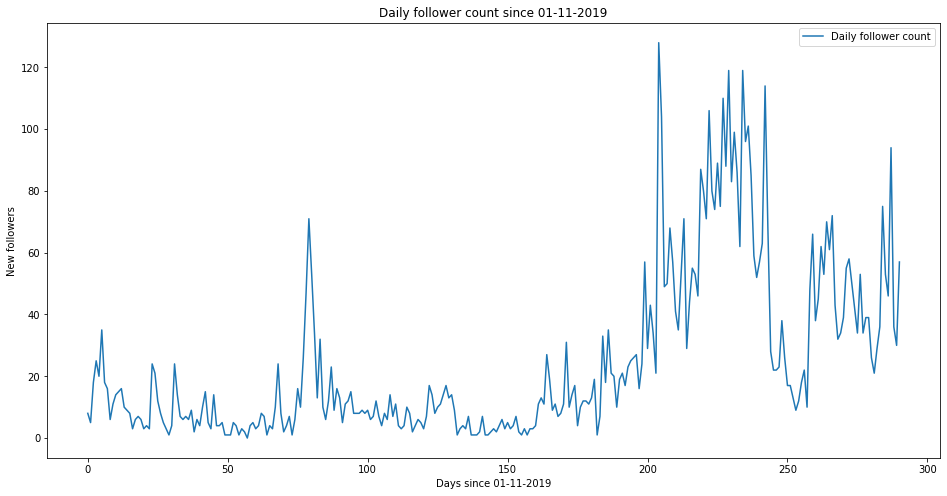

In [126]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since 01-11-2019')
ax.set_ylabel('New followers')
ax.set_title('Daily follower count since 01-11-2019')
ax.plot(total_days, data['follower_count'], label = 'Daily follower count')
ax.legend();

### Daily reach and daily new followers

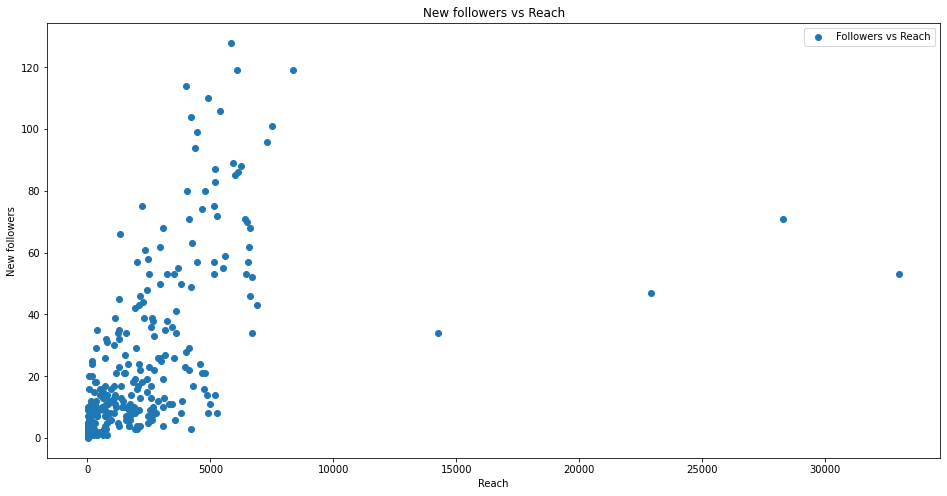

In [127]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Reach')
ax.set_ylabel('New followers')
ax.set_title('New followers vs Reach')
ax.scatter(data['reach'], data['follower_count'], label = 'Followers vs Reach')
ax.legend();

### Daily follower and reach without (apparent) outliers

#### Linear fit

Residual sum of squares (RSS): 96268.87779318444
Total sum of squares (TSS): 210709.49825783973
R squared: 0.5431203690904208


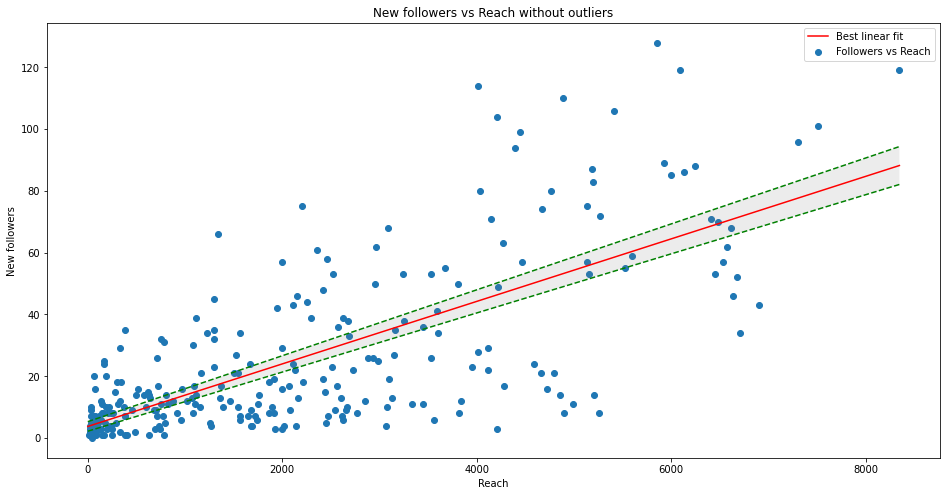

In [128]:
import scipy.optimize as optimization

def func(x, a, b):
    return a*x + b

data_notl_reach = data.loc[data['reach'] < 10000]

fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Reach')
ax.set_ylabel('New followers')
ax.set_title('New followers vs Reach without outliers')
ax.scatter(data_notl_reach['reach'], data_notl_reach['follower_count'], label = 'Followers vs Reach')

# Build best lineear fit using scipy
xdata = np.array(data_notl_reach['reach'])
ydata = np.array(data_notl_reach['follower_count'])
x0    = np.array([0.0, 0.0])

popt, pcov = optimization.curve_fit(func, xdata, ydata, x0)
perr = np.sqrt(np.diag(pcov))
max_val = data_notl_reach['reach'].max()
x_vals = np.arange(0, max_val, 0.1)

fit = []
fit_plus = []
fit_minus = []
for x in x_vals:
    fit.append(func(x, popt[0], popt[1]))
    fit_minus.append(func(x, popt[0] - perr[0], popt[1] - perr[1]))
    fit_plus.append(func(x, popt[0] + perr[0], popt[1] + perr[1]))
    
ax.plot(x_vals, fit, color = 'r', label = 'Best linear fit');
ax.plot(x_vals, fit_plus, color = 'g', linestyle = '--');
ax.plot(x_vals, fit_minus, color = 'g', linestyle = '--');
ax.fill_between(x_vals, fit_minus, fit_plus, facecolor = 'gray', alpha = 0.15);
ax.legend()

residuals = ydata - func(xdata, *popt)
ss_res = np.sum(residuals**2)
print("Residual sum of squares (RSS): " + str(ss_res))
ss_tot = np.sum((ydata - np.mean(ydata))**2)
print("Total sum of squares (TSS): " + str(ss_tot))
r_squared = 1 - (ss_res / ss_tot)
print("R squared: " + str(r_squared))

#### Quadratic fit

Residual sum of squares (RSS): 94872.9790819469
Total sum of squares (TSS): 210709.49825783973
R squared: 0.5497451236590516


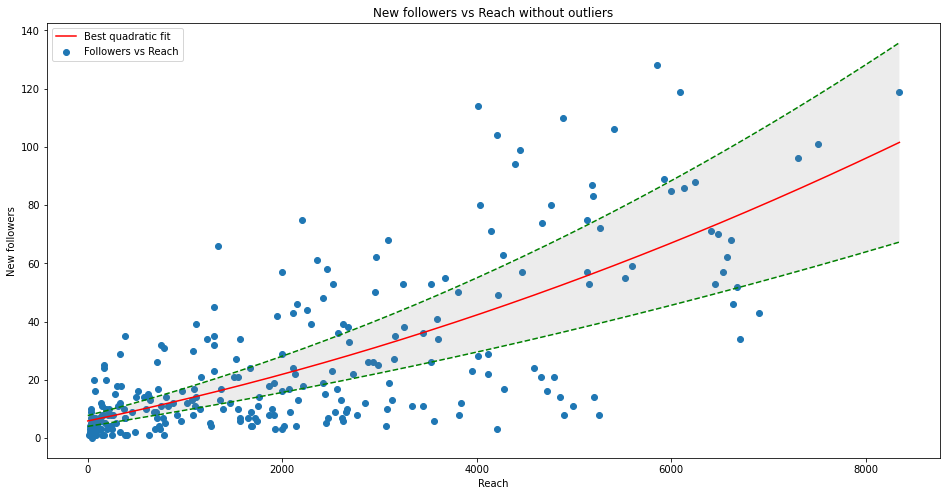

In [129]:
def func(x, a, b, c):
    return a*x**2 + b*x + c

data_notl_reach = data.loc[data['reach'] < 10000]

fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Reach')
ax.set_ylabel('New followers')
ax.set_title('New followers vs Reach without outliers')
ax.scatter(data_notl_reach['reach'], data_notl_reach['follower_count'], label = 'Followers vs Reach')

# Build best quadratic fit using scipy
xdata = np.array(data_notl_reach['reach'])
ydata = np.array(data_notl_reach['follower_count'])
x0    = np.array([0.0, 0.0, 0.0])

popt, pcov = optimization.curve_fit(func, xdata, ydata, x0)
perr = np.sqrt(np.diag(pcov))
max_val = data_notl_reach['reach'].max()
x_vals = np.arange(0, max_val, 0.1)

fit = []
fit_plus = []
fit_minus = []
for x in x_vals:
    fit.append(func(x, popt[0], popt[1], popt[2]))
    fit_minus.append(func(x, popt[0] - perr[0], popt[1] - perr[1], popt[2] - perr[2]))
    fit_plus.append(func(x, popt[0] + perr[0], popt[1] + perr[1], popt[2] + perr[2]))
    
ax.plot(x_vals, fit, color = 'r', label = 'Best quadratic fit');
ax.plot(x_vals, fit_plus, color = 'g', linestyle = '--');
ax.plot(x_vals, fit_minus, color = 'g', linestyle = '--');
ax.fill_between(x_vals, fit_minus, fit_plus, facecolor = 'gray', alpha = 0.15)
ax.legend()

residuals = ydata - func(xdata, *popt)
ss_res = np.sum(residuals**2)
print("Residual sum of squares (RSS): " + str(ss_res))
ss_tot = np.sum((ydata - np.mean(ydata))**2)
print("Total sum of squares (TSS): " + str(ss_tot))
r_squared = 1 - (ss_res / ss_tot)
print("R squared: " + str(r_squared))

### How many people that were reached followed me?

Mean: 0.029878613070174375
Variance: 0.0019522652894633087


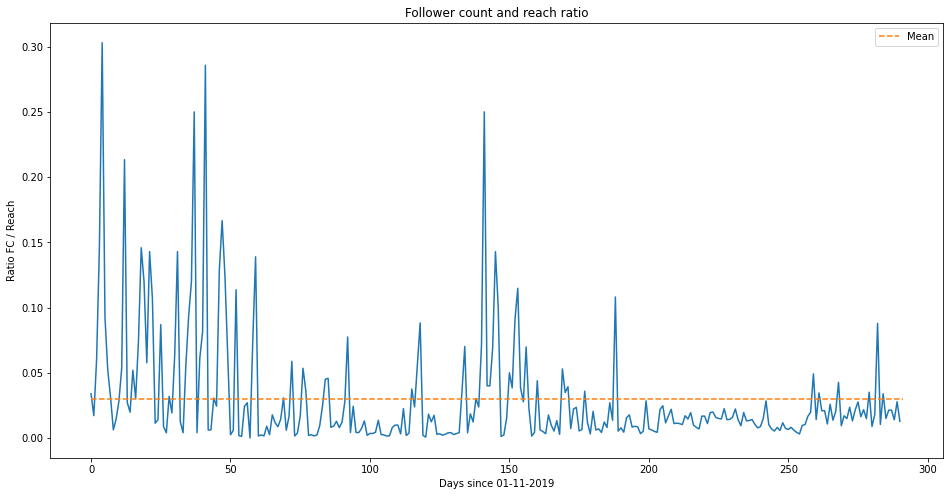

In [130]:
# I.e: What percentage of the reached people followed me.
reach_ratios = data['follower_count'] / data['reach']

fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since 01-11-2019')
ax.set_ylabel('Ratio FC / Reach')
ax.set_title('Follower count and reach ratio')
ax.plot(total_days, reach_ratios)
ax.plot(total_days, [np.mean(reach_ratios)] * len(total_days), label = 'Mean', linestyle = '--')

ax.legend()

print("Mean: " + str(np.mean(reach_ratios)))
print("Variance: " + str(np.var(reach_ratios)))

### When were the highest ratios?

In [131]:
sorted_ratios = reach_ratios.sort_values(ascending = False)
sorted_ratios.head(n = 10)

date
2019-11-05    0.303030
2019-12-12    0.285714
2020-03-21    0.250000
2019-12-08    0.250000
2019-11-13    0.213333
2019-12-18    0.166667
2019-11-04    0.146199
2019-11-19    0.145833
2019-12-02    0.142857
2019-11-22    0.142857
dtype: float64

## Profile views analysis

### Profile views historic values

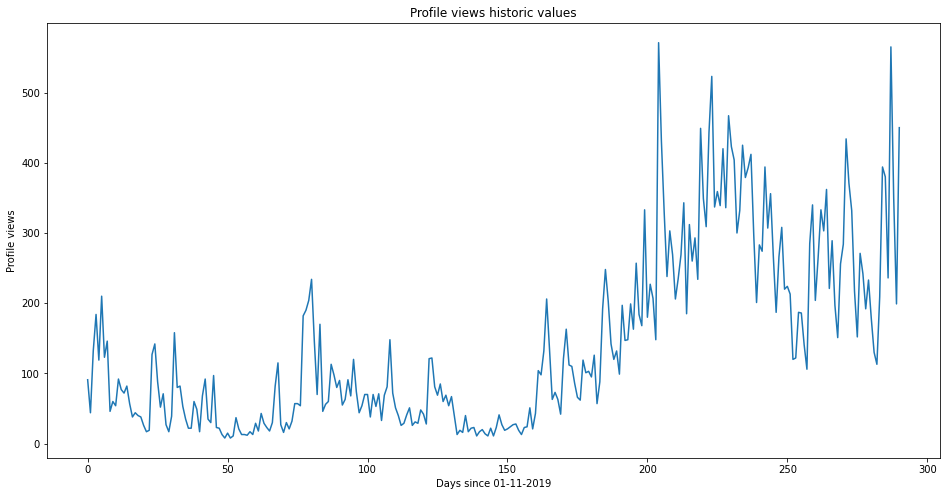

In [132]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since 01-11-2019')
ax.set_ylabel('Profile views')
ax.set_title('Profile views historic values')
ax.plot(total_days, data['profile_views']);

### Follower increase and profile views

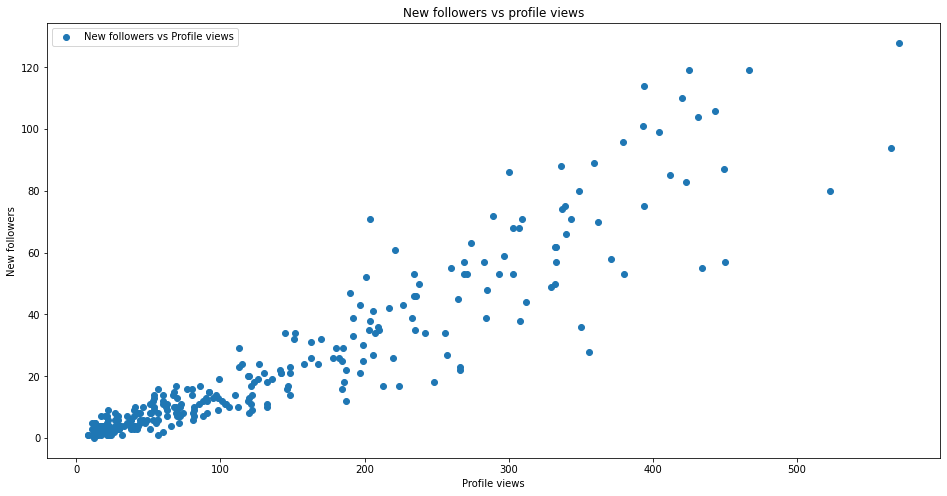

In [133]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Profile views')
ax.set_ylabel('New followers')
ax.set_title('New followers vs profile views')
ax.scatter(data['profile_views'], data['follower_count'], label = 'New followers vs Profile views')
ax.legend();

### How many people that saw my profile, followed me?

Mean: 0.16162666171275725
Variance: 0.004924603598965582


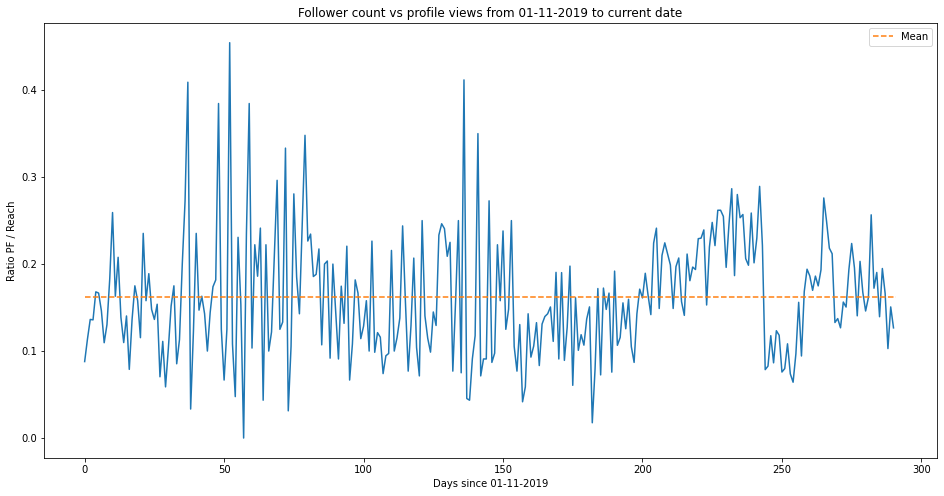

In [134]:
# I.e: What percentage of the people that saw my profile followed me.
profile_ratios = data['follower_count'] / data['profile_views']


fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since 01-11-2019')
ax.set_ylabel('Ratio PF / Reach')
ax.set_title('Follower count vs profile views from 01-11-2019 to current date')
ax.plot(total_days, profile_ratios)
ax.plot(total_days, [np.mean(profile_ratios)] * len(total_days), label = 'Mean', linestyle = '--')

ax.legend()

print("Mean: " + str(np.mean(profile_ratios)))
print("Variance: " + str(np.var(profile_ratios)))

### When where the highest ratios?

In [135]:
sorted_ratios = profile_ratios.sort_values(ascending = False)
sorted_ratios.head(n = 10)

date
2019-12-23    0.454545
2020-03-16    0.411765
2019-12-08    0.409091
2019-12-30    0.384615
2019-12-19    0.384615
2020-03-21    0.350000
2020-01-19    0.348039
2020-01-12    0.333333
2020-01-09    0.296296
2020-06-30    0.289340
dtype: float64

### How many people that saw my profile, clicked on my website?

Mean: 0.014070249309245973
Variance: 0.00035099518301816556


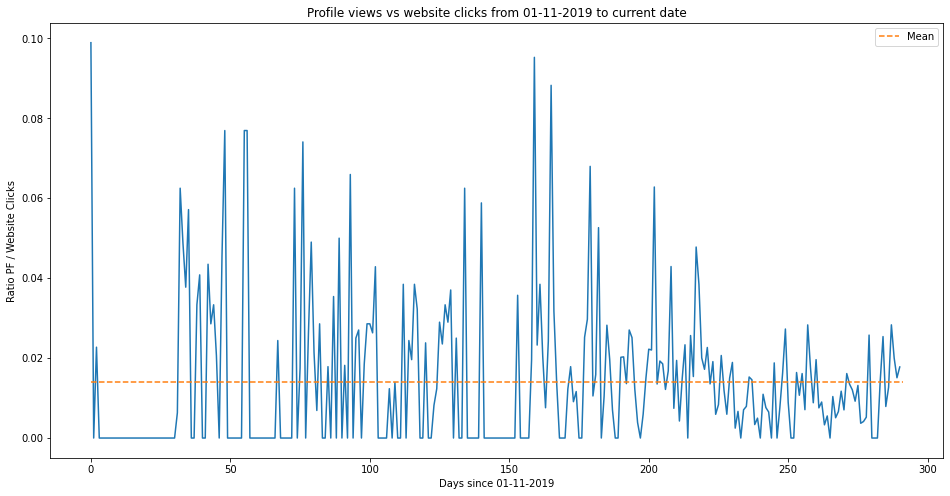

In [136]:
# I.e: What percentage of the people that saw my profile clicked on my website.
website_click_ratios = data['website_clicks'] / data['profile_views']

fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since 01-11-2019')
ax.set_ylabel('Ratio PF / Website Clicks')
ax.set_title('Profile views vs website clicks from 01-11-2019 to current date')
ax.plot(total_days, website_click_ratios)
ax.plot(total_days, [np.mean(website_click_ratios)] * len(total_days), label = 'Mean', linestyle = '--')

ax.legend()

print("Mean: " + str(np.mean(website_click_ratios)))
print("Variance: " + str(np.var(website_click_ratios)))

### When where the highest ratios?

In [137]:
sorted_ratios = website_click_ratios.sort_values(ascending = False)
sorted_ratios.head(n = 10)

date
2019-11-01    0.098901
2020-04-08    0.095238
2020-04-14    0.088235
2019-12-27    0.076923
2019-12-26    0.076923
2019-12-19    0.076923
2020-01-16    0.074074
2020-04-28    0.067961
2020-02-02    0.065934
2020-05-21    0.062802
dtype: float64

## Total follower analysis

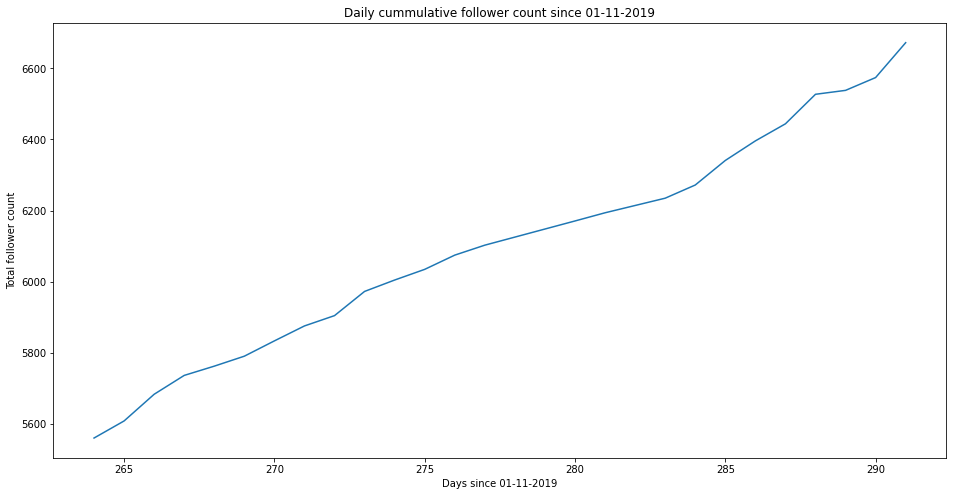

In [138]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since 01-11-2019')
ax.set_ylabel('Total follower count')
ax.set_title('Daily cummulative follower count since 01-11-2019')
ax.plot(total_days, data['total_follower_count']);

### Deriving actual new daily followers from follower count

Mean: 41.148148148148145


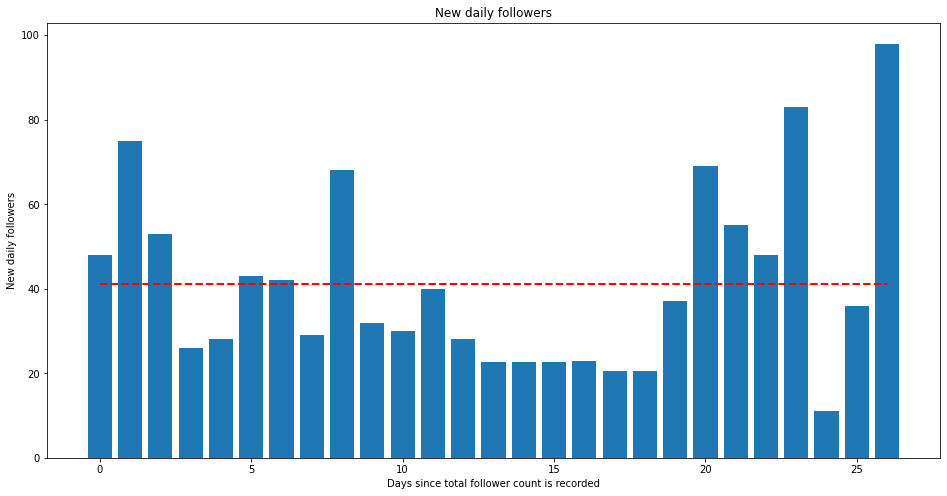

In [139]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since total follower count is recorded')
ax.set_ylabel('New daily followers')
ax.set_title('New daily followers')

ax.bar(np.arange(total_follower_count_len), daily_followers)
ax.plot(np.arange(total_follower_count_len), [np.mean(daily_followers)] * total_follower_count_len, 
        color = 'r', linestyle = '--', linewidth = '2')

print("Mean: " + str(np.mean(daily_followers)))

### Follower projections

#### Linear projection using the mean and no variance

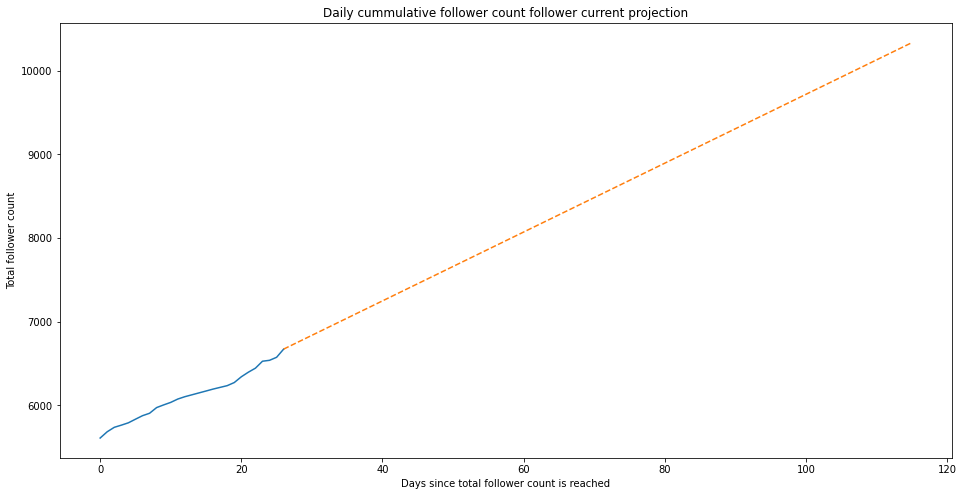

In [140]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since total follower count is reached')
ax.set_ylabel('Total follower count')
ax.set_title('Daily cummulative follower count follower current projection')

ax.plot(total_follower_count_days, data['total_follower_count'][init_follower_count_index:]);

current_projection = current_init
mean = np.mean(daily_followers)
current = data['total_follower_count'][init_follower_count_index:][total_follower_count_len - 1]
for i in range(projection_len):
    current_projection[i] = current
    current += mean

ax.plot(np.arange(projection_start, projection_end), current_projection, linestyle = '--');

#### Past projections versus current projection

In [156]:
from datetime import datetime

past_projections = {}
with open('linear_projections.csv', 'r+') as f:
    text = f.read()
    splitted = text.split("]\n")
    for i in range(len(splitted) - 1):
        splitted_projection = splitted[i].split(",[")

        date = splitted_projection[0]
        time_series = splitted_projection[1].split(",")
        past_projections[date] = time_series
    
    current_date = datetime.today().strftime('%Y-%m-%d')
    if not current_date in past_projections:
        f.write(datetime.today().strftime('%Y-%m-%d') + "," + str([i for i in current_projection]) + '\n')

#### Projection with daily new follower historic data's best fit

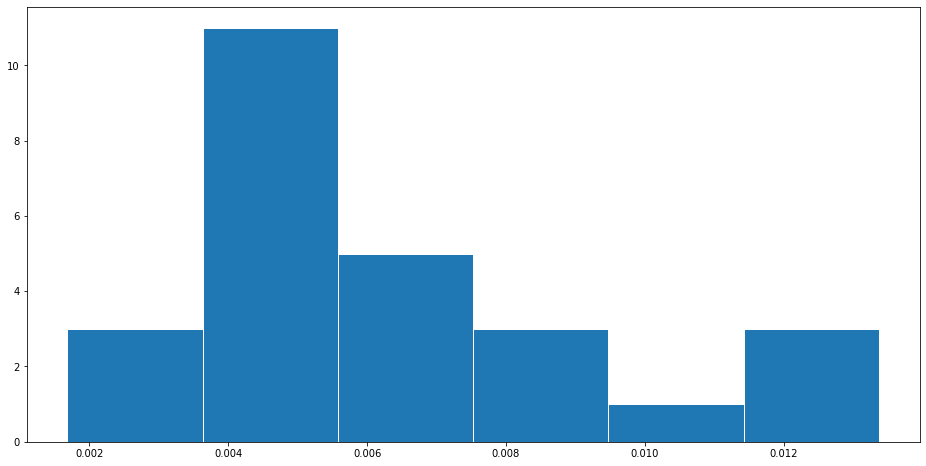

In [157]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.hist(daily_followers_pct, bins = 'sturges', histtype='bar', ec = 'white');

['ksone', 'kstwo', 'kstwobign', 'norm', 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'fisk', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'fatiguelife', 'foldcauchy', 'f', 'foldnorm', 'weibull_min', 'weibull_max', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gamma', 'erlang', 'gengamma', 'genhalflogistic', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'gausshyper', 'invgamma', 'invgauss', 'geninvgauss', 'norminvgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'laplace', 'levy', 'levy_l', 'levy_stable', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'gilbrat', 'maxwell', 'mielke', 'kappa4', 'kappa3', 'moyal', 'nakagami', 'ncx2', 'ncf', 't', 'nct', 'pareto', 'lomax', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'rayleigh', 'loguniform', 'reciprocal', 'rice', 'recipinvgauss', 'semicircular', 'skewn

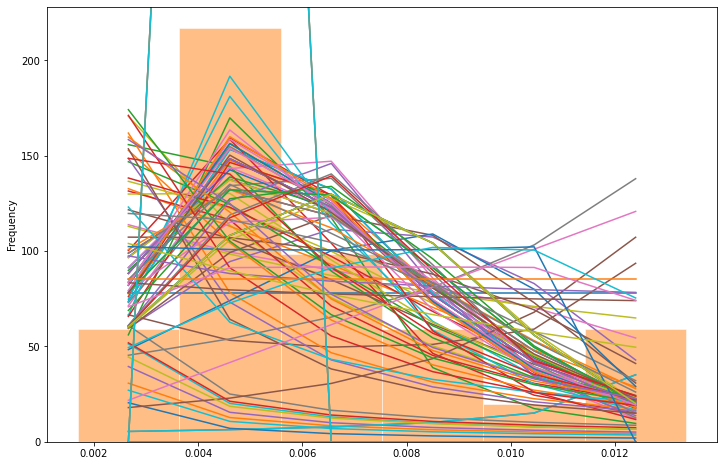

In [159]:
# https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats._continuous_distns import _distn_names

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)

# Create models from data
def best_fit_distribution(data, bins=200, ax=None, dataYLim=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    print(_distn_names)
    # Distributions to check

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution_name in _distn_names:
        distribution = getattr(st, distribution_name) 
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax = ax, ylim = dataYLim)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
# data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())
series = pd.Series(daily_followers_pct)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = series.plot(kind='hist', bins='sturges', histtype='bar', ec = 'white', density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(series, 'sturges', ax, dataYLim)
best_dist = getattr(st, best_fit_name)

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params);

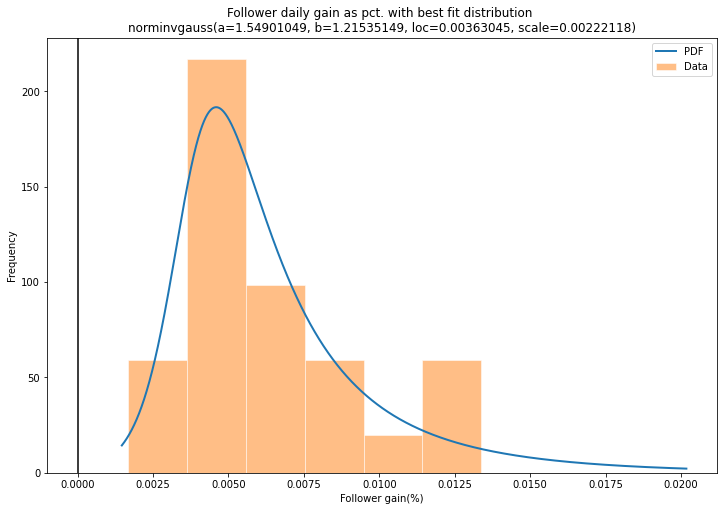

In [160]:
# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
series.plot(kind='hist', bins='sturges', histtype='bar', ec = 'white', density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.8f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Follower daily gain as pct. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Follower gain(%)')
ax.set_ylabel('Frequency')
ax.axvline(x = 0, color = 'k');

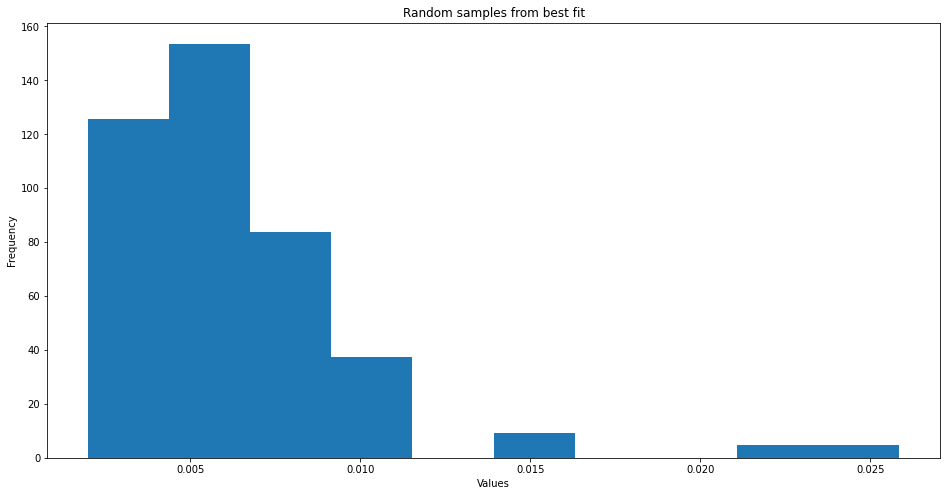

In [161]:
param_dictionary = {}
for k,v in zip(param_names, best_fit_params):
    param_dictionary[k] = v

best_fit_projection = best_dist.rvs(**param_dictionary, size = projection_len)
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('Random samples from best fit')
ax.hist(best_fit_projection, density = True);

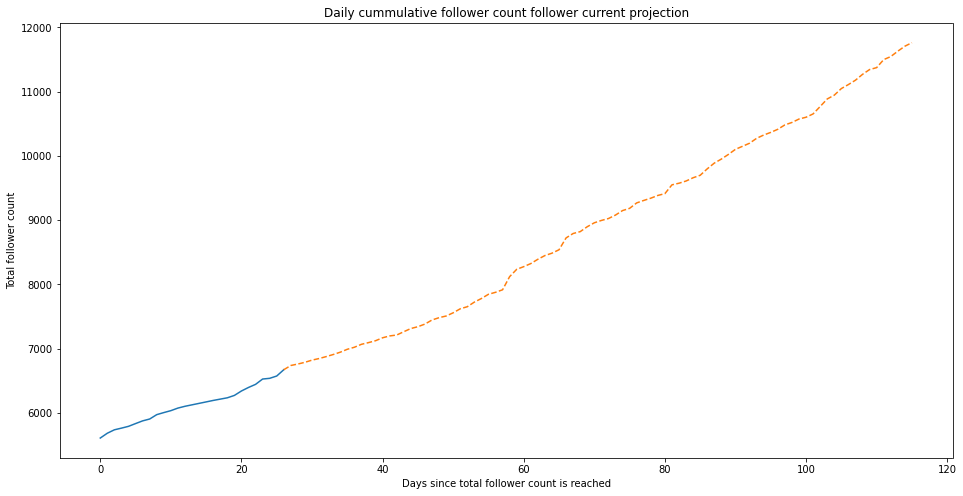

In [162]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since total follower count is reached')
ax.set_ylabel('Total follower count')
ax.set_title('Daily cummulative follower count follower current projection')

ax.plot(total_follower_count_days, data['total_follower_count'][init_follower_count_index:]);

current_projection = current_init
mean = np.mean(daily_followers)

current = data['total_follower_count'][init_follower_count_index:][total_follower_count_len - 1]
for i in range(projection_len):
    current_projection[i] = current
    current *= (1 + best_fit_projection[i])

ax.plot(np.arange(projection_start, projection_end), current_projection, linestyle = '--');

#### Best fit comparison

In [168]:
from datetime import datetime

past_projections = {}
with open('best_fit_projections.csv', 'r+') as f:
    text = f.read()
    splitted = text.split("]\n")
    for i in range(len(splitted) - 1):
        splitted_projection = splitted[i].split(",[")
        date = splitted_projection[0]
        time_series = splitted_projection[1].split(",")
        past_projections[date] = time_series
    
    current_date = datetime.today().strftime('%Y-%m-%d')
    if not current_date in past_projections:
        f.write(datetime.today().strftime('%Y-%m-%d') + "," + str([i for i in current_projection]) + '\n')

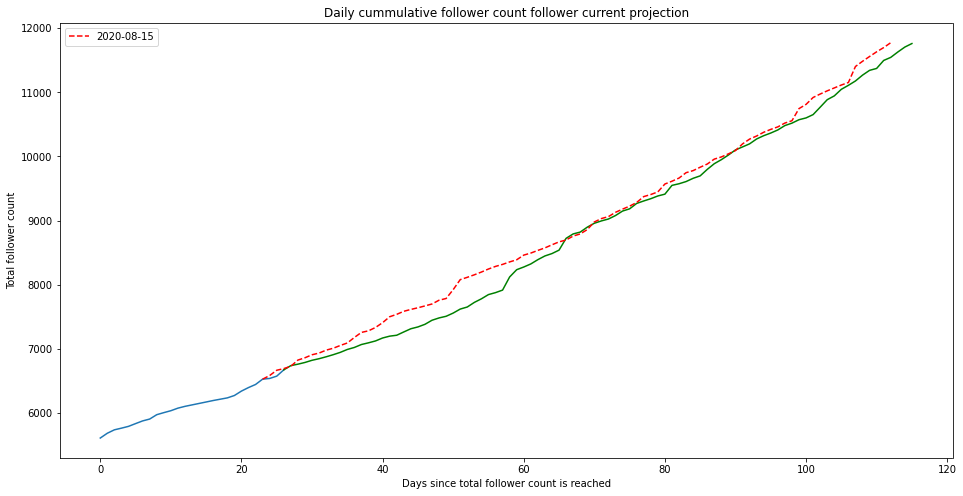

In [169]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

ax.set_xlabel('Days since total follower count is reached')
ax.set_ylabel('Total follower count')
ax.set_title('Daily cummulative follower count follower current projection')

ax.plot(total_follower_count_days, data['total_follower_count'][init_follower_count_index:]);

current_projection = current_init
mean = np.mean(daily_followers)

current = data['total_follower_count'][init_follower_count_index:][total_follower_count_len - 1]
for i in range(projection_len):
    current_projection[i] = current
    current *= (1 + best_fit_projection[i])

ax.plot(np.arange(projection_start, projection_end), current_projection, color = 'green');

for date, series in past_projections.items():
    diff_date = (datetime.today().date() - datetime.strptime(date, "%Y-%m-%d").date()).days
    ax.plot(np.arange(projection_start - diff_date, projection_end - diff_date), 
            [float(value) for value in series], linestyle = '--', color = 'red', label = date)
    ax.legend();